# Tutorial - Bayesian Logistic Regression

The purpose of this tutorial is to show how to build a simple Bayesian model to deduce the line which separates two categories of points.

## Problem

A *logistic model* is a statistical model where we have a collection of things that can be divided into two categories -- pictures of cats or dogs, patients who are immune or susceptible, students who pass or fail, and so on. An assumption of the model is: the probability that a given thing is in a category can be computed by taking a linear combination of characteristics of the thing.

The problem we seek to solve in this tutorial is: *when given a set of examples of each category, can we infer the boundary between the categories?*

In [1]:
# unittest
import os
import torch
import beanmachine.ppl as bm
from torch import manual_seed, randint, tensor
from torch.distributions import Bernoulli, Normal, Uniform
import matplotlib.pyplot as plt
import logging

logging.getLogger("beanmachine").setLevel(50)
manual_seed(8); # This makes the results deterministic and reproducible.

smoke_test = ('SANDCASTLE_NEXUS' in os.environ or 'CI' in os.environ)

## Example: orange and blue points

For the purposes of this tutorial our "things" will be two-dimensional points between $(-10, -10)$ and $(10, 10)$. Our two categories will be represented by $0.0$, which we'll render as blue, and $1.0$, which we'll render as orange.

The probability that a given point $(x, y)$ will be orange is 

$P((x, y)\text{ is orange}) = \Large{\frac{1}{1 + e^{-b_0 - b_1 x - b_2 y}}}$

for some coefficients $b_0, b_1, b_2$.

That equation is seen to be a linear combination of properties of the point if we express the probability as log odds:

$logit(P((x, y)\text{ is orange})) = b_0 + b_1 x + b_2 y$

The boundary between the two categories is the set of points where the probability is $0.5$ that the point is orange; the log odds of $0.5$ is $0$, so the equation of the set of $(x, y)$ points separating the categories is a straight line:

$b_0 + b_1 x + b_2 y = 0$

Or, expressed as slope and intercept:

$y = -\frac{b_1}{b_2}x - \frac{b_0}{b_2}$

Our goal therefore is to infer possible values for $b_0, b_1, b_2$ from which we can compute the line separating the categories.

## Creating sample data

We start by creating a data set to illustrate the model.  In order to make computations faster and easier, we will express the entire data set as a single tensor representing 200 points. Each row of the tensor will be in the form $\begin{bmatrix}1.0&x&y\end{bmatrix}$. That way we can compute the linear combination by matrix-multiplying each row by $\begin{bmatrix}b_0 \\ b_1 \\ b_2\end{bmatrix}$ to obtain the log odds that the point is orange: $b_0 + b_1 x + b_2 y$.

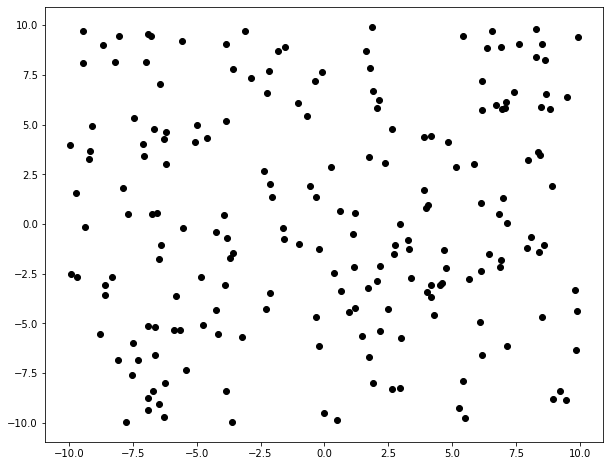

In [2]:
n = 200
low = -10.0
high = 10.0
uniform = Uniform(low=tensor([1.0, low, low]), high=tensor([1.0, high, high]))
points = tensor([uniform.sample().tolist() for i in range(n)]).view(n, 3)

plt.figure(figsize=(10,8))
for point in points:
    plt.scatter(point[1], point[2], c='black')

We now assign points to categories $0.0$ (blue) and $1.0$ (orange). 

For this example we will assign categories to points using $\begin{bmatrix}-2.0 \\ 0.3 \\ -0.5\end{bmatrix}$ as our coefficients, which makes the line separating the categories $y = 0.6 x - 4$.

In [3]:
true_coefficients = tensor([-2.0, 0.3, -0.5]).view(3, 1)
true_slope = -float(true_coefficients[1] / true_coefficients[2])
true_intercept = -float(true_coefficients[0] / true_coefficients[2])

def log_odds(point):
    return point.view(1, 3).mm(true_coefficients)

observed_categories = tensor([Bernoulli(logits=log_odds(point)).sample() for point in points])

## Data visualization methods

It is useful to have helper methods to visualize the test data set and the line which separates the two categories:

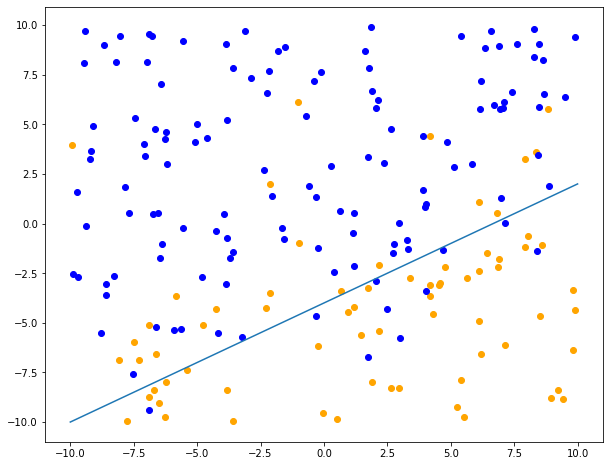

In [4]:
def plot_line(slope, intercept):
    if intercept > high or intercept < low:
        return
    xs = [low, high]
    ys = [slope * low + intercept, slope * high + intercept]
    if ys[0] > high:
        xs[0] = (high - intercept) / slope
        ys[0] = high
    elif ys[0] < low:
        xs[0] = (low - intercept) / slope
        ys[0] = low
    if ys[1] > high:
        xs[1] = (high - intercept) / slope
        ys[1] = high
    elif ys[1] < low:
        xs[1] = (low - intercept) / slope
        ys[1] = low
    plt.plot(xs, ys)

def plot_points(ps, cs):
    for p, c in zip(ps, cs):
        plt.scatter(p[1], p[2], c=('orange' if c == 1.0 else 'blue'))

plt.figure(figsize=(10,8))
plot_points(points, observed_categories)
plot_line(true_slope, true_intercept)

## Model

We can now start building our model. 

The first thing we need is a prior distribution for our three coefficients.

We have no reason to believe that the coefficients will be either positive or negative, so we should choose a prior distribution that is centered on zero.  We use a matrix multiplication to compute the linear combination, and therefore make the prior a column vector of samples from a normal distribution:

In [5]:
@bm.random_variable
def coefficients():
    mean = torch.zeros(3, 1)
    sigma = torch.ones(3, 1)
    return Normal(mean, sigma)

Our model for categories is now straightforward: each category is chosen by matrix-multiplying the point by the prior distribution of coefficients, and we get a set of categories from the Bernoulli distribution; either $0.0$ (blue) or $1.0$ (orange):

In [6]:
@bm.random_variable
def categories():
    return Bernoulli(logits=points.mm(coefficients()))

## Inference

We can now infer the posterior distribution of the coefficients given the observations:

In [7]:
num_samples = 2 if smoke_test else 500
num_adaptive_samples = 0 if smoke_test else 500
num_chains = 1
observations = {categories() : observed_categories.view(n, 1)}
queries = [coefficients()]
mc = bm.GlobalNoUTurnSampler()
%time samples = mc.infer(queries, observations, num_samples, \
                         num_chains, num_adaptive_samples)
sampled_coefficients = samples.get_chain()[coefficients()]

Samples collected:   0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 3.93 s, sys: 75.7 ms, total: 4.01 s
Wall time: 4.04 s


The slopes and intercepts are computed from the sampled coefficients:

In [8]:
slopes = [-float(s[1] / s[2]) for s in sampled_coefficients if float(s[2]) != 0.0]
intercepts = [-float(s[0] / s[2]) for s in sampled_coefficients if float(s[2]) != 0.0]


## Posterior results

A histogram of the inferred slopes should cluster near the true value, marked in red. A slight deviation is to be expected since there is noise in our data.

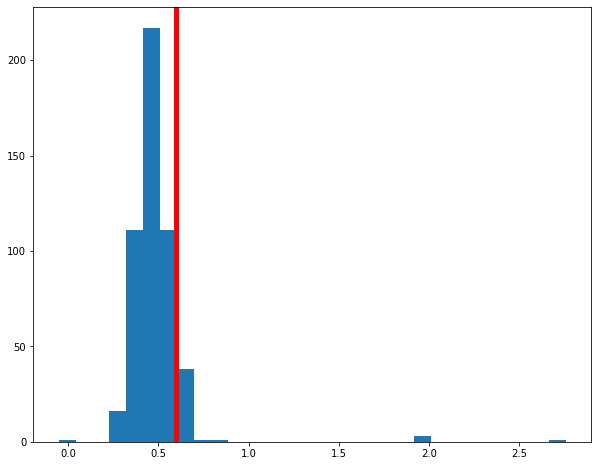

In [9]:
plt.figure(figsize=(10,8))
plt.hist(slopes, bins=30)
plt.axvline(x=true_slope, c='red', linewidth=5);

And similarly for the intercepts. Our model actually predicts a higher median intercept to capture the orange points above the slope in our ground truth.

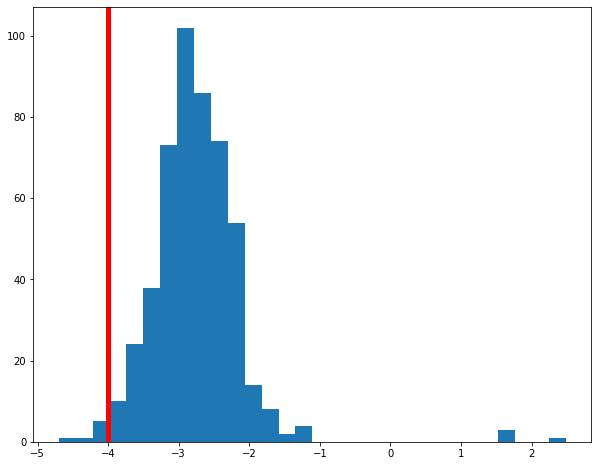

In [10]:
plt.figure(figsize=(10,8))
plt.hist(intercepts, bins=30)
plt.axvline(x=true_intercept, c='red', linewidth=5);

Inference typically finds a reasonable distribution of possible lines that separate these two categories.

## Diagnostics

In addition to visualizing the lines directly, we can also use the diagnostics capabilities of Bean Machine to examine the deduced values of the coefficients; recall that the true coefficients were $-2.0$, $0.3$ and $-0.6$:

In [11]:
bm.Diagnostics(samples).summary()

,avg,std,2.5%,50%,97.5%,n_eff
"coefficients()[0, 0]",-1.169547,0.220285,-1.596676,-1.152711,-0.768563,341.702850
"coefficients()[1, 0]",0.191887,0.042517,0.113970,0.193785,0.276164,261.729645
"coefficients()[2, 0]",-0.417973,0.052362,-0.522218,-0.411455,-0.316531,348.234131


As you can see, the average and median (50%) values inferred are reasonably close to the true values but there is a large spread. Remember that *any constant multiple of the true values would produce the same line*; if we got $-4.0$, $0.6$ and $-1.2$ then the slope and intercept would be the same and only the amount of "mixing" near the line would change, so we can expect that this inference problem may have some fairly large variance.

The `n_eff` column is the effective sample size, which indicates how correlated the posterior samples are to each other; higher is better. This effective sample size is a little low.

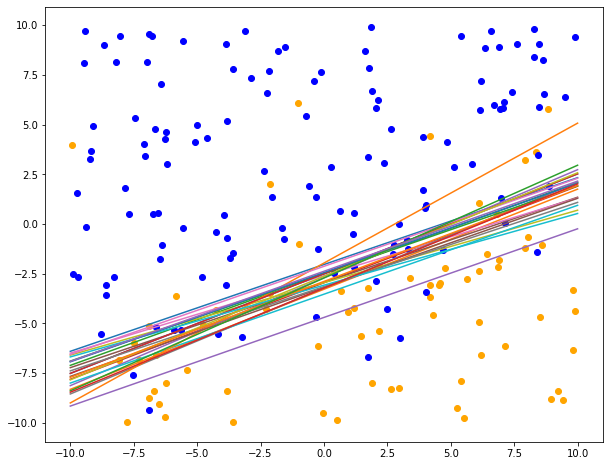

In [12]:
plt.figure(figsize=(10,8))
plot_points(points, observed_categories)
num_lines = 25
for i in randint(0, len(slopes), (num_lines,)):
    plot_line(slopes[i], intercepts[i])

Notice that we generated the data by separating points along a line with slope $0.6$ and intercept $-4.0$, but were we to observe the *specific* set of 200 points we classified without knowing the true parameters ahead of time, we would deduce that the separating line had a slightly slower slope than $0.6$ and an intercept around $-3.0$. 

To more clearly illustrate the accuracy of the inference, we can take a random selection of the inferred lines and plot them on the data set: